
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=10>
    Deep Learning - HW4 <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    winter 2024<br>
<font color=3C99D size=5>
    Practical Assignment 1 <br>
<font color=696880 size=4>
    Niloufar Abbasi 

____

# Emotion Recognition with Recurrent Neural Networks


---

## **Introduction**

In this task, you will implement a Recurrent Neural Network (RNN) to perform tweet emotion recognition. The goal is to classify tweets into one of six basic emotions: 
- **0: sadness**
- **1: joy**
- **2: love**
- **3: anger**
- **4: fear**
- **5: surprise**

We will be using a dataset of tweets, where each tweet has been labeled with one of these emotions. Throughout this notebook, you will follow step-by-step instructions to build and train your model. As you progress, you'll complete the provided TODO sections by filling in the necessary code and functions.

By the end of this exercise, you will:
- Understand how to preprocess text data for use in RNN models.
- Build and train a model using Pytorch.
- Evaluate the performance of your model on the test set.

---


---

## Task 1: Enter Your Information

Before we begin, please enter your **student ID** and **name** in the code section below.

Make sure to replace the placeholders with your actual information.

---

In [1]:
#########################################
# TODO: Enter your personal information #
#########################################

student_name = 'EhsanMerrikhi'  # Replace with your name
student_id   = 400101967  # Replace with your student ID

print("Your name:", student_name)
print("Your student ID:", student_id)

Your name: EhsanMerrikhi
Your student ID: 400101967


---

## Task 2: Setup and Imports

In this task, we'll be preparing our environment by importing the necessary libraries. Please run the cells below to set everything up. If any library is missing on your end, make sure to install it.

### Instructions:
1. **Run the cells** to install any required packages and import the necessary libraries.
2. If any library is not installed in your environment, use `!pip install <library_name>` to install it.
---

In [3]:
!pip install datasets

Required Libraries:

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datasets import load_dataset

%matplotlib inline

#####################################################################
# TODO: Add any additional libraries you may need for your analysis #
#####################################################################
 
# You can add your libraries here
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from collections import Counter
import seaborn as sns
from torchinfo import summary
import copy

### Additional Functions

The following functions have been provided to help you visualize the results of your model training. These will allow you to analyze both the model's performance over time (through the training history) and how well it performs on individual predictions (through a confusion matrix).

1. **`plot_history(hist)`**: This function takes the training history object (`hist`) from your model and plots both the accuracy and loss over the number of epochs for both training and validation sets. It provides an easy way to visually track the model's learning progress and performance.

2. **`visualize_confusion_matrix(actual_labels, predicted_labels, classes)`**: After making predictions with your model, you can use this function to plot a confusion matrix. It shows the accuracy of your model across each class, helping to identify areas where the model is performing well and where it might be struggling. The matrix is normalized to make comparisons easier.

These functions are for your convenience, you can directly use them after running your model to visualize the results.


In [4]:
# Functions to visualize training history and confusion matrix
def plot_history(hist):
    epochs = len(hist['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), hist.get('accuracy'), label='Training Accuracy', marker='o')
    plt.plot(range(1, epochs + 1), hist.get('val_accuracy'), label='Validation Accuracy', marker='o')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), hist.get('loss'), label='Training Loss', marker='o')
    plt.plot(range(1, epochs + 1), hist.get('val_loss'), label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def visualize_confusion_matrix(actual_labels, predicted_labels, classes):

    cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


---

## Task 3: Importing Data

In this task, we will

- import the Tweet Emotion dataset

- create training, validation, and test sets
    
- extract the tweets and their corresponding labels for further analysis

---

In [5]:
dataset = load_dataset('emotion')
dataset

README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
# Display the first few samples
print(dataset['train'][0:5])  # Adjust 'train' to 'test' or other splits if necessary

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [7]:
###########################################################################
# TODO: Create variables for the training, validation, and test datasets. #
###########################################################################

training = dataset['train']
validation = dataset['validation']
test = dataset['test']

In [8]:
########################################################################################################
# TODO:                                                                                                #
# Implement the `extract_tweets_labels` function to iterate over the provided dataset.                 #
# Within this function, extract the tweet text and their corresponding labels into two separate lists. #
# Then, call this function with the training dataset to obtain the tweets and labels,                  #
# ensuring proper data handling for subsequent analysis.                                               #
########################################################################################################

def extract_tweets_labels(data):
    # Extract the text and labels from the data
    tweets = []
    labels = []
    for sample in data:
        tweets.append(sample['text'])
        labels.append(sample['label'])
    return tweets, labels

# Get the tweets and labels from the training set
tweets, labels = extract_tweets_labels(training)

# Display the first tweet and its label
print(tweets[0], labels[0])


i didnt feel humiliated 0


---

## Task 4: Tokenization of Tweets

In this section, we will focus on the tokenization of the tweets in the dataset. Tokenization is a crucial step in natural language processing (NLP) that involves breaking down text into smaller units, such as words or subwords. This process enables the model to better understand and analyze the text data.

### Objectives:
1. Implement a tokenizer to convert the tweet texts into tokens.
2. Ensure the tokenization process handles various aspects of the text, such as punctuation and special characters.

By the end of this task, you will have a set of tokenized tweets ready for further processing in your NLP pipeline.

---

In [9]:
###############################################################################################################################################
# TODO: Tokenization of Tweets                                                                                                                #
# 1. Select a Tokenization Method: Choose a suitable tokenization method to preprocess the tweets.                                            #                                 
# Ensure that the tokenization handles special characters and maintains the integrity of the text data.                                       #
# 2. Implement the Tokenizer: Once you have selected a method, implement the tokenizer to convert the tweet texts into sequences of tokens.   #
# 3. Test the Tokenization:                                                                                                                   #
# Verify the functionality of your tokenizer by applying it to a sample tweet from the dataset and displaying the resulting tokenized output. #
###############################################################################################################################################



# BERTweet tokenizer suitable for tweets
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base', use_fast=True)

# Step 5: Define the tokenization function for the dataset
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

# Tokenize the datasets
tokenized_training = training.map(tokenize_function, batched=True)
tokenized_validation = validation.map(tokenize_function, batched=True)
tokenized_test = test.map(tokenize_function, batched=True)

# Step 6: Set the format to PyTorch tensors
tokenized_training.set_format(type='torch', columns=['input_ids', 'attention_mask', 'token_type_ids', 'label'])
tokenized_validation.set_format(type='torch', columns=['input_ids', 'attention_mask', 'token_type_ids', 'label'])
tokenized_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'token_type_ids', 'label'])

# Step 7: Test the tokenization on a sample
sample = tokenized_training[0]
print("Tokenized Input IDs:", sample['input_ids'])
print("Attention Mask:", sample['attention_mask'])

# Decode the input IDs back to tokens for readability
decoded_tokens = tokenizer.convert_ids_to_tokens(sample['input_ids'])
print("\nDecoded Tokens:")
print(decoded_tokens)

# Decode back to the original text to check integrity
decoded_text = tokenizer.decode(sample['input_ids'], skip_special_tokens=True)
print("\nDecoded Text:")
print(decoded_text)

config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Tokenized Input IDs: tensor([    0,    37,  1403,   174, 45115,     2,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1, 

---

## Task 5: Padding and Truncating Sequences

In this task, we will prepare the tokenized tweets for model training by checking their lengths and creating padded sequences.

1. **Checking the Length of the Tweets**
   - Analyze the distribution of tweet lengths to understand the range of token counts in the dataset.

2. **Creating Padded Sequences**
   - After tokenizing the tweets, sequences of different lengths must be adjusted to a uniform length to facilitate training.

---


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Mean Length: 21.7968125
Median Length: 20.0
Maximum Length: 82
Standard Deviation: 11.354785437860274
50th Percentile: 20.0
75th Percentile: 28.0
90th Percentile: 38.0
95th Percentile: 44.0
99th Percentile: 56.0


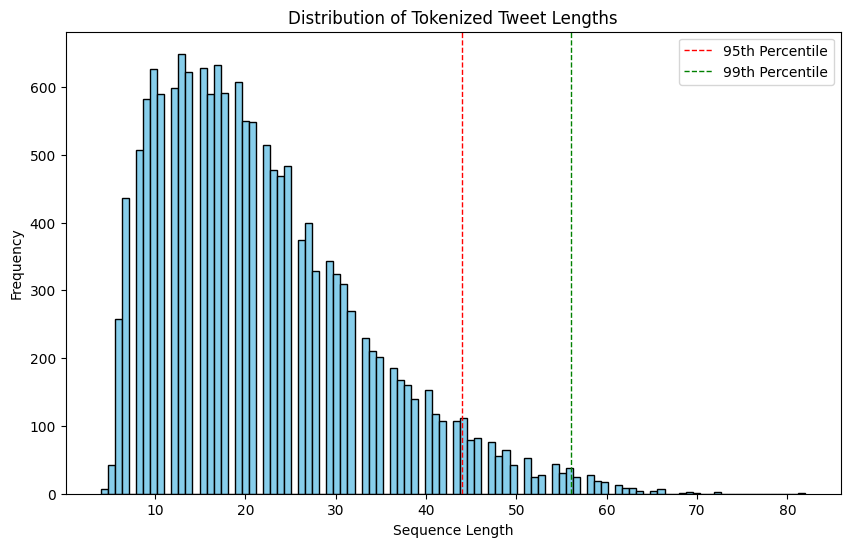

Chosen max_length (95th percentile): 44


In [10]:
#####################################################################################################################################################
# TODO:                                                                                                                                             #
# Implement code to calculate the lengths of the tweets and visualize the distribution using a histogram. Use an appropriate visualization library. #
# After visualizing the distribution, determine a suitable maximum length for padding and truncating the sequences based on your findings.          #
#####################################################################################################################################################


# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base', use_fast=True)

# Tokenize without truncation to calculate lengths
def tokenize_without_truncation(examples):
    return tokenizer(
        examples['text'],
        padding=False,
        truncation=False,
        return_length=True
    )

tokenized_training = training.map(tokenize_without_truncation, batched=True)
lengths = np.array(tokenized_training['length'])

# Analyze the lengths
mean_length = np.mean(lengths)
median_length = np.median(lengths)
max_length = np.max(lengths)
std_length = np.std(lengths)

print(f"Mean Length: {mean_length}")
print(f"Median Length: {median_length}")
print(f"Maximum Length: {max_length}")
print(f"Standard Deviation: {std_length}")

# Calculate percentiles
percentiles = [50, 75, 90, 95, 99]
percentile_values = np.percentile(lengths, percentiles)
for p, v in zip(percentiles, percentile_values):
    print(f"{p}th Percentile: {v}")

# Visualize the distribution
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Tokenized Tweet Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axvline(np.percentile(lengths, 95), color='red', linestyle='dashed', linewidth=1, label='95th Percentile')
plt.axvline(np.percentile(lengths, 99), color='green', linestyle='dashed', linewidth=1, label='99th Percentile')
plt.legend()
plt.show()

# Choose max_length (e.g., 95th percentile)
chosen_max_length = int(np.percentile(lengths, 95))
print(f"Chosen max_length (95th percentile): {chosen_max_length}")

In [15]:
############################################################################################################
# TODO: Define a function to convert the tokenized tweets into sequences and apply padding and truncation. # 
# Use your determined maximum length for padding the sequences.                                            #
############################################################################################################

def get_sequences(tokenizer, tweets):
    sequences = tokenizer(
        tweets,
        padding='max_length',         
        truncation=True,              
        max_length=chosen_max_length, 
        return_attention_mask=True,   
        return_token_type_ids=True, 
        return_tensors='pt'           
    )
    padded_sequences = {
        'input_ids': sequences['input_ids'],
        'attention_mask': sequences['attention_mask'],
        'token_type_ids': sequences['token_type_ids']
    }
    return padded_sequences


padded_train_sequences = get_sequences(tokenizer, tweets)
padded_train_sequences['input_ids'][0]

tensor([    0,    37,  1403,   174, 45115,     2,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1])

---

## Task 6: Analyzing Label Distribution

1. Checking the distribution of labels.
2. Addressing any class imbalance using appropriate techniques.

Note:

(**Providing a clear explanation of the chosen method to address the imbalance and how it will improve the model’s performance is critical.** Without handling class imbalance properly, the model could achieve a high accuracy by focusing on the majority class, but it may perform poorly on the minority class, which would result in misleading metrics and reduced generalization.

Hence, it is important to not only implement an appropriate solution but also **justify** why the selected approach is effective for the given task.)

---

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


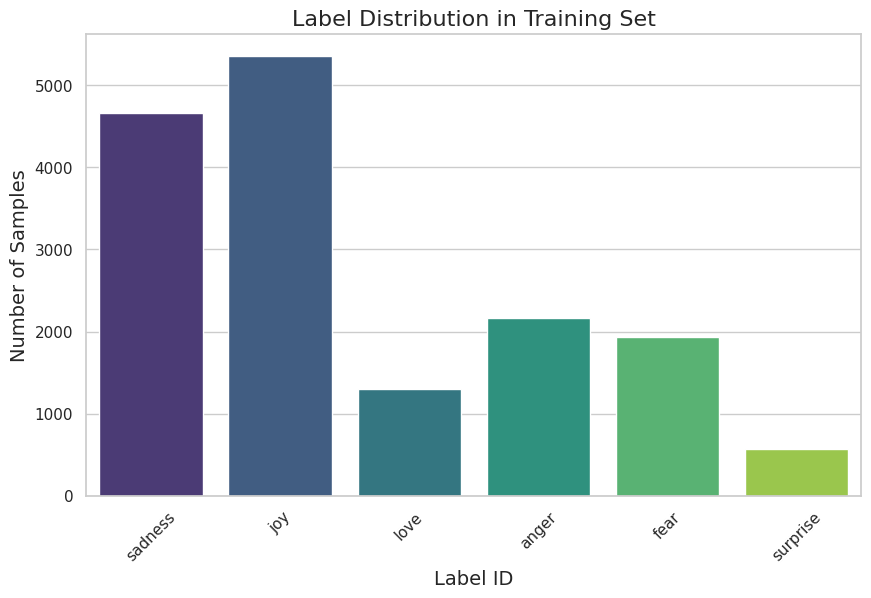

Class Weights (to address imbalance):
Class sadness (ID 0): 0.5715
Class anger (ID 3): 1.2351
Class love (ID 2): 2.0450
Class surprise (ID 5): 4.6620
Class fear (ID 4): 1.3767
Class joy (ID 1): 0.4973


In [16]:
##########################################################################################################################
# TODO: Analyze the distribution of labels in the training set. (visualize it in a perfect way)                          #
# Determine if there is any class imbalance.                                                                             #
# If you observe any imbalance, apply one of the techniques you have learned throughout the course to address the issue. #
##########################################################################################################################

labels = tokenized_training['label']

label_counts = Counter(labels)

labels_sorted = sorted(label_counts.items(), key=lambda x: x[0])
label_ids, counts = zip(*labels_sorted)

label_mapping = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
label_names = [label_mapping[label_id] for label_id in label_ids]

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x=list(label_names), y=list(counts), palette="viridis")

plt.title("Label Distribution in Training Set", fontsize=16)
plt.xlabel("Label ID", fontsize=14)
plt.ylabel("Number of Samples", fontsize=14)
plt.xticks(rotation=45)
plt.show()


# Class imbalance can be observed in this dataset.
# To solve the problem we will use class weights method
total_samples = sum(counts)
class_weights = {label_id: total_samples / (len(label_ids) * count) for label_id, count in label_counts.items()}
weights = torch.tensor([class_weights[label_id] for label_id in label_ids], dtype=torch.float)

print("Class Weights (to address imbalance):")
for label_id, weight in class_weights.items():
    print(f"Class {label_mapping[label_id]} (ID {label_id}): {weight:.4f}")

---

## Task 7: Creating the Model

Design and implement a recurrent neural network for the task. You may utilize a sequential architecture like RNN or GRU to enhance the model's performance.

Build and compile your model using Pytorch.

**Once the model is created, summarize its structure to verify the design.**

---

In [17]:
#########################################################################################################
# TODO:                                                                                                 #
# Create a recurrent neural network model for the task.                                                 #
# (Suggestion: Implement a Bidirectional LSTM architecture to process the input sequences effectively.) #
# Once the model is created, summarize its structure to verify the design.                              #
#########################################################################################################

# Define and Instantiate the BiLSTM Model

class EmotionClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(EmotionClassifier, self).__init__()
        
        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Bidirectional LSTM Layer
        self.lstm = nn.LSTM(embed_dim,
                            hidden_dim,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            batch_first=True,
                            dropout=dropout if n_layers > 1 else 0)
        
        # Dropout Layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        # input_ids: [batch_size, seq_length]
        
        # Embedding
        embedded = self.embedding(input_ids)
        # embedded: [batch_size, seq_length, embed_dim]
        
        # LSTM
        lstm_out, (hidden, cell) = self.lstm(embedded)
        # lstm_out: [batch_size, seq_length, hidden_dim * 2]
        # hidden: [num_layers * 2, batch_size, hidden_dim]
        
        # Concatenate the final forward and backward hidden states
        if self.lstm.bidirectional:
            # hidden[-2,:,:] is the last layer's forward hidden state
            # hidden[-1,:,:] is the last layer's backward hidden state
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        # hidden: [batch_size, hidden_dim * 2] or [batch_size, hidden_dim]
        
        # Fully Connected Layer
        output = self.fc(hidden)
        # output: [batch_size, output_dim]
        
        return output

# Define hyperparameters
vocab_size = tokenizer.vocab_size  # Size of the tokenizer's vocabulary
embed_dim = 100                     # Dimension of embedding vectors
hidden_dim = 256                    # Number of hidden units in LSTM
output_dim = len(label_ids)  # Number of emotion classes
n_layers = 2                        # Number of LSTM layers
bidirectional = True                # Use bidirectional LSTM
dropout = 0.3                       # Dropout rate
pad_idx = tokenizer.pad_token_id    # Padding token ID

# Instantiate the model
model = EmotionClassifier(vocab_size,
                          embed_dim,
                          hidden_dim,
                          output_dim,
                          n_layers,
                          bidirectional,
                          dropout)

# Step 8: Summarize the Model Structure Using torchinfo

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

batch_size = 64
seq_length = chosen_max_length

summary(
    model,
    input_size=[
        (batch_size, seq_length),       # input_ids
        (batch_size, seq_length),       # attention_mask
        (batch_size, seq_length)        # token_type_ids
    ],
    dtypes=[torch.long, torch.long, torch.long]
)


Layer (type:depth-idx)                   Output Shape              Param #
EmotionClassifier                        [64, 6]                   --
├─Embedding: 1-1                         [64, 44, 100]             6,400,000
├─LSTM: 1-2                              [64, 44, 512]             2,310,144
├─Dropout: 1-3                           [64, 512]                 --
├─Linear: 1-4                            [64, 6]                   3,078
Total params: 8,713,222
Trainable params: 8,713,222
Non-trainable params: 0
Total mult-adds (G): 6.92
Input size (MB): 0.07
Forward/backward pass size (MB): 13.79
Params size (MB): 34.85
Estimated Total Size (MB): 48.71

---

## Task 8: Training the Model

In this task, you will prepare a validation set and train your model using the training data.

1. Prepare the validation set by extracting tweets and labels, and convert them into sequences using the tokenizer.
2. Train the model on the training data.
3. Ensure that you implement **Early Stopping** to prevent overfitting and enhance efficiency.

Make sure to monitor the validation accuracy during training and adjust the parameters as necessary.

---

In [18]:
###############################################################################################################
# TODO: Extract the tweets and labels from the validation set. Convert the tweets into sequences using the    #
#       tokenizer defined earlier. Prepare the data for validation and ensure it matches the format of the    #
#       training set.                                                                                         #
###############################################################################################################

# Extract tweets and labels from the validation set
validation_tweets, validation_labels = extract_tweets_labels(validation)

# Tokenize the validation tweets using the get_sequences function
validation_sequences = get_sequences(tokenizer, validation_tweets)

# Create a TensorDataset for the validation data
validation_dataset = TensorDataset(
    validation_sequences['input_ids'],
    validation_sequences['attention_mask'],
    validation_sequences['token_type_ids'],
    torch.tensor(validation_labels)
)

# Create a DataLoader for the validation dataset
validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=False       
)


# Extract tweets and labels from the training set
train_tweets, train_labels = extract_tweets_labels(training)

# Tokenize the training tweets using the get_sequences function
train_sequences = get_sequences(tokenizer, train_tweets)

# Create a TensorDataset for the training data
train_dataset = TensorDataset(
    train_sequences['input_ids'],
    train_sequences['attention_mask'],
    train_sequences['token_type_ids'],
    torch.tensor(train_labels)
)

# Create a DataLoader for the training dataset
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True  # Shuffle for training
)

###############################################################################################################
# TODO: Train the model on the prepared training data. Ensure you implement early stopping to monitor the     #
#       validation accuracy and prevent overfitting. Adjust the number of epochs or other hyperparameters as  #
#       needed to optimize model performance.                                                                 #
###############################################################################################################

def train_model(model,
               train_dataloader,
               validation_dataloader,
               criterion,
               optimizer,
               scheduler,
               device,
               num_epochs=30,
               patience=3):
    
    best_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # Initialize history lists with keys expected by plot_history
    history = {
        'loss': [],
        'accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in range(num_epochs):
        if early_stop:
            print("Early stopping triggered.")
            break

        # -------------------
        # Training Phase
        # -------------------
        model.train()
        epoch_loss = 0
        epoch_correct = 0

        for batch in train_dataloader:
            input_ids, attention_mask, token_type_ids, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(input_ids, attention_mask, token_type_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            epoch_loss += loss.item()

            # Calculate accuracy
            _, preds = torch.max(outputs, dim=1)
            epoch_correct += torch.sum(preds == labels)

        epoch_loss /= len(train_dataloader)
        epoch_acc = epoch_correct.double() / len(train_dataloader.dataset)

        # Append training metrics to history
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc.item())

        # -------------------
        # Validation Phase
        # -------------------
        model.eval()
        val_loss = 0
        val_correct = 0

        with torch.no_grad():
            for batch in validation_dataloader:
                input_ids, attention_mask, token_type_ids, labels = batch
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                token_type_ids = token_type_ids.to(device)
                labels = labels.to(device)

                outputs = model(input_ids, attention_mask, token_type_ids)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                # Calculate accuracy
                _, preds = torch.max(outputs, dim=1)
                val_correct += torch.sum(preds == labels)

        val_loss /= len(validation_dataloader)
        val_acc = val_correct.double() / len(validation_dataloader.dataset)

        # Append validation metrics to history
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc.item())

        # Print epoch metrics
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

        # -------------------
        # Early Stopping Check
        # -------------------
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            print("Validation loss decreased. Saving model...")
        else:
            epochs_no_improve += 1
            print(f"No improvement in validation loss for {epochs_no_improve} epoch(s).")
            if epochs_no_improve >= patience:
                print("Early stopping!")
                early_stop = True

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history


criterion = nn.CrossEntropyLoss(weight=weights.to(device))

# Define the optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20          # Maximum number of epochs
patience = 3            # Number of epochs to wait for improvement before stopping

total_steps = len(train_dataloader) * num_epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Train the model using the train_model function
model, history = train_model(
    model=model,
    train_dataloader=train_dataloader,
    validation_dataloader=validation_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=num_epochs,
    patience=patience
)

# (Optional) Save the training history for future analysis
torch.save(history, 'training_history.pth')

Epoch 1/20
Train Loss: 1.6967 | Train Acc: 0.2152
Val Loss: 1.4987 | Val Acc: 0.2130
Validation loss decreased. Saving model...
Epoch 2/20
Train Loss: 1.3202 | Train Acc: 0.3522
Val Loss: 1.1169 | Val Acc: 0.4315
Validation loss decreased. Saving model...
Epoch 3/20
Train Loss: 0.8747 | Train Acc: 0.5557
Val Loss: 0.7064 | Val Acc: 0.6250
Validation loss decreased. Saving model...
Epoch 4/20
Train Loss: 0.4850 | Train Acc: 0.7914
Val Loss: 0.4175 | Val Acc: 0.8415
Validation loss decreased. Saving model...
Epoch 5/20
Train Loss: 0.2853 | Train Acc: 0.8809
Val Loss: 0.3158 | Val Acc: 0.8725
Validation loss decreased. Saving model...
Epoch 6/20
Train Loss: 0.1916 | Train Acc: 0.9198
Val Loss: 0.2682 | Val Acc: 0.8905
Validation loss decreased. Saving model...
Epoch 7/20
Train Loss: 0.1424 | Train Acc: 0.9376
Val Loss: 0.3248 | Val Acc: 0.8920
No improvement in validation loss for 1 epoch(s).
Epoch 8/20
Train Loss: 0.1212 | Train Acc: 0.9467
Val Loss: 0.3126 | Val Acc: 0.8850
No improveme

---

## Task 9: Evaluating the Model

In this task, you will evaluate the performance of your model on the test set and visualize the training history. You will also analyze the model’s predictions on both individual and complete test samples.

### Steps:
1. Visualize the loss and accuracy over the training epochs.
2. Prepare and preprocess the test data using functions from Task 2.
3. Evaluate the model on the test set and examine individual predictions.
4. Analyze the overall predictions and display a confusion matrix.

---

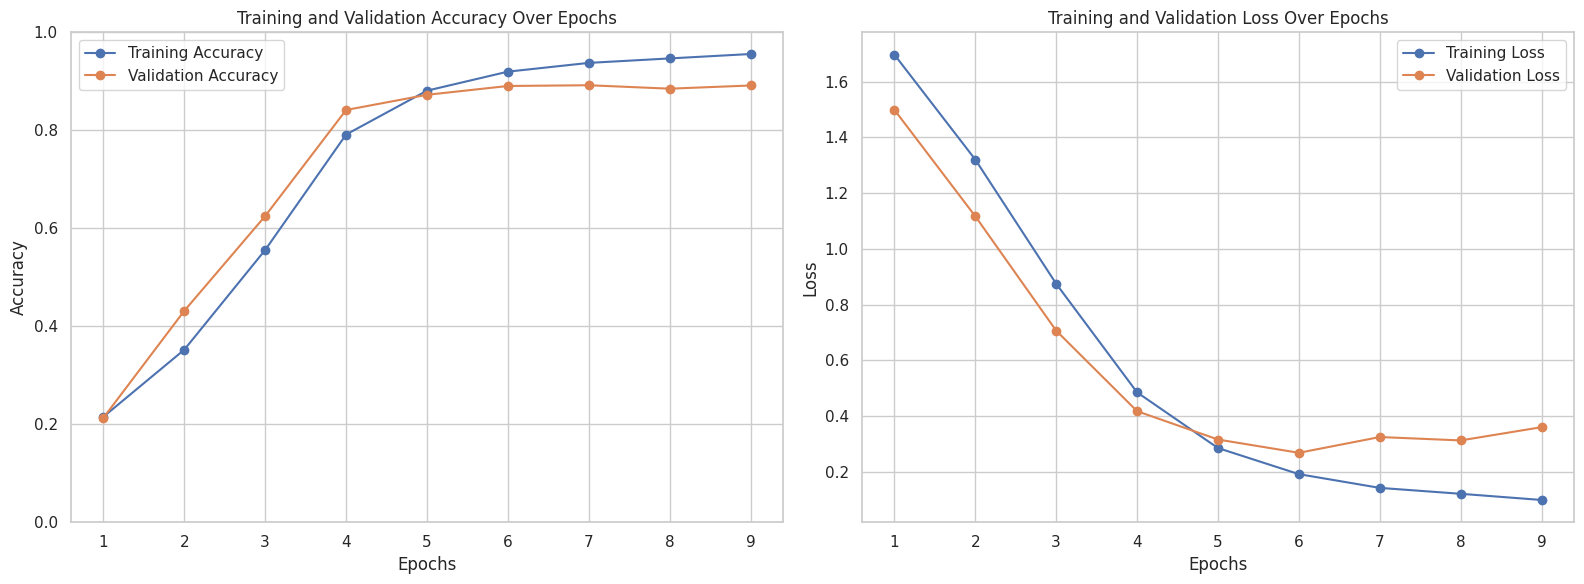

In [19]:
###############################################################################################################
# TODO: Visualize the training history by plotting the loss and accuracy over the epochs to assess model      #
#       performance. Use an appropriate visualization method to ensure clarity and effectiveness.             #
#       you can use function implemented in Task 2 for your visualizations                                    #
###############################################################################################################

# Your code for visualizing the training history goes here
plot_history(history)


In [20]:
###############################################################################################################
# TODO: Prepare the test set by extracting the tweets and labels, then convert the tweets into sequences using #
#       the tokenizer. Ensure the format matches that of the training and validation sets.                     #
###############################################################################################################

# Your code for preparing the test set goes here
# Extract tweets and labels from the training set
test_tweets, test_labels = extract_tweets_labels(test)

# Tokenize the training tweets using the get_sequences function
test_sequences = get_sequences(tokenizer, test_tweets)

# Create a TensorDataset for the training data
test_dataset = TensorDataset(
    test_sequences['input_ids'],
    test_sequences['attention_mask'],
    test_sequences['token_type_ids'],
    torch.tensor(test_labels)
)

# Create a DataLoader for the training dataset
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True  # Shuffle for training
)

In [21]:
###############################################################################################################
# TODO: Evaluate the model's performance on the test set. Print the accuracy and loss, and review individual   #
#       predictions to understand how the model is performing on unseen data.                                 #
###############################################################################################################

def evaluate_model(model, dataloader, criterion, device):
    
    model.eval()
    total_loss = 0
    total_correct = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, token_type_ids, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask, token_type_ids)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            total_correct += torch.sum(preds == labels)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_correct.double() / len(dataloader.dataset)

    return (avg_loss, avg_acc), all_labels, all_preds

# Evaluate the model on the test set
(test_loss, test_acc), test_actual_labels, test_predicted_labels = evaluate_model(
    model=model,
    dataloader=test_dataloader,
    criterion=criterion,
    device=device
)

print(f'\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}\n')



Test Loss: 0.3389 | Test Accuracy: 0.8820



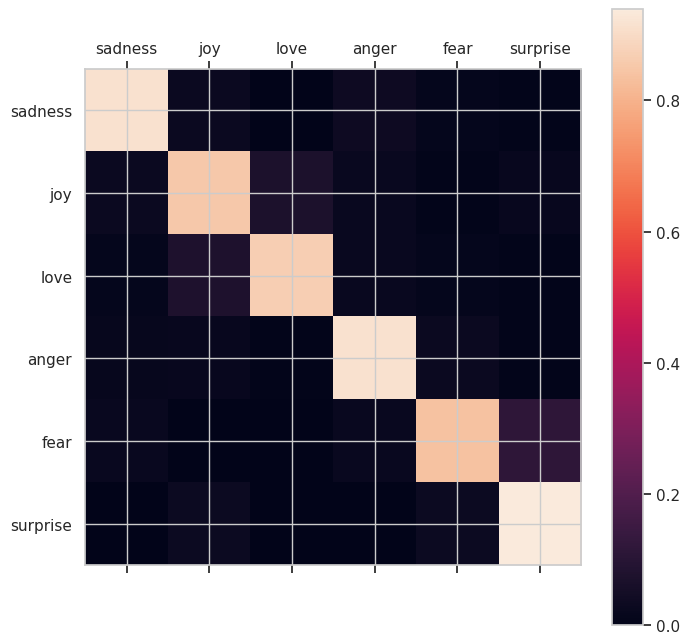

Sample Predictions:
-------------------
Tweet: im feeling rather rotten so im not very ambitious right now
Actual Label: sadness
Predicted Label: sadness

Tweet: im updating my blog because i feel shitty
Actual Label: sadness
Predicted Label: sadness

Tweet: i never make her separate from me because i don t ever want her to feel like i m ashamed with her
Actual Label: joy
Predicted Label: love

Tweet: i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived
Actual Label: joy
Predicted Label: joy

Tweet: i was feeling a little vain when i did this one
Actual Label: anger
Predicted Label: anger



In [22]:
###############################################################################################################
# TODO: Generate predictions for all test samples and analyze the model's overall performance. Display the     #
#       confusion matrix to visualize the differences between true and predicted labels, helping to interpret  #
#       the model's classification results.                                                                   #
###############################################################################################################

# Visualize the confusion matrix
classes = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
visualize_confusion_matrix(test_actual_labels, test_predicted_labels, classes)

# Review individual predictions
num_samples_to_review = 5 
print("Sample Predictions:")
print("-------------------")
for i in range(num_samples_to_review):
    print(f"Tweet: {test_tweets[i]}")
    print(f"Actual Label: {classes[test_actual_labels[i]]}")
    print(f"Predicted Label: {classes[test_predicted_labels[i]]}\n")


# Final Analysis

After visualizing the confusion matrix based on your model’s predictions, analyze the results and provide insights into the model’s classification performance.

### **Question:**
<span style="font-size: 1.2em;">Which class seems to get confused with the class *love* the most?</span>

**Remember the class labels:**
- **0:** *Sadness*
- **1:** *Joy*
- **2:** *Love*
- **3:** *Anger*
- **4:** *Fear*
- **5:** *Surprise*

Reflect on the confusion matrix to answer this question and provide your reasoning for why this confusion might occur based on the emotional nature of the classes.


In [25]:
# Assuming you have test_actual_labels and test_predicted_labels from evaluation
cm = confusion_matrix(test_actual_labels, test_predicted_labels, normalize='true')

# Index for 'Love' class
love_index = classes.index('love')  # This will be 2 based on the classes list

# Extract the row corresponding to 'Love' in the confusion matrix
love_confusion = cm[love_index]

# Exclude the correct prediction by setting the diagonal element to 0
love_confusion_no_diag = np.copy(love_confusion)
love_confusion_no_diag[love_index] = 0

# Find the index of the class with the highest confusion with 'Love'
most_confused_class_index = np.argmax(love_confusion_no_diag)

# Get the class name
most_confused_class = classes[most_confused_class_index]

print(f"The class most confused with 'Love' is: {most_confused_class}")

# Optional: Print the confusion values for 'Love'
print("\nConfusion values for 'Love':")
for i, class_name in enumerate(classes):
    if i != love_index:
        print(f"{class_name}: {love_confusion[i]:.2f}")


The class most confused with 'Love' is: joy

Confusion values for 'Love':
sadness: 0.01
joy: 0.08
anger: 0.03
fear: 0.01
surprise: 0.01


# **Best regards.**